# Solving the Shallow Water Equations

In [1]:
%matplotlib inline
import mkl
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
mkl.set_num_threads(4)

In [2]:
def bump(x, x0, d):
    ret = np.zeros(x.shape[0])
    mask = np.logical_and(x>=x0-d, x<=x0+d)
    with np.errstate(divide='ignore'):
        ret[mask] = np.exp(-1/(d**2-(x[mask]-x0)**2))
    return ret

In [3]:
def gaussian(x, x0, d):
    return np.exp(-((x-x0)**2.)/(2.*d**2))

In [4]:
#Initial condition functions
def h0(x):
    x0 = 50
    d = 2
    ret = gaussian(x, x0, d)
    ret *= 0.2
    ret += 1
    return ret

def u0(x):
    #return 2*(1./(1.+np.exp(-x+10)))-1
    return np.zeros(x.shape[0])

#spatial boundary
a = 0
b = 100

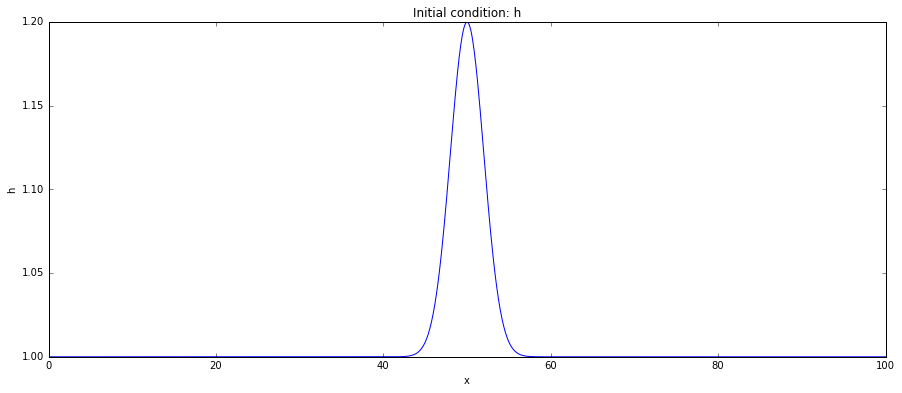

In [5]:
x = np.linspace(a, b, 1000)
plt.figure(figsize=(15,6))
plt.xlabel('x')
plt.ylabel('h')
plt.title('Initial condition: h')
plt.plot(x,h0(x))
plt.show()

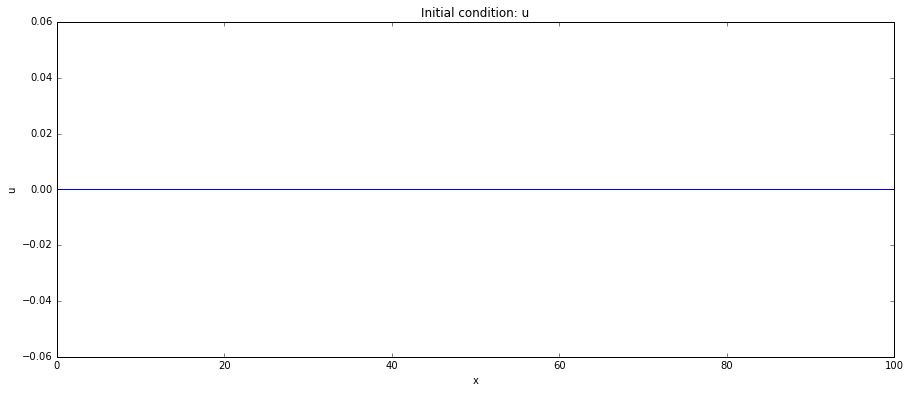

In [6]:
plt.figure(figsize=(15,6))
plt.xlabel('x')
plt.ylabel('u')
plt.title('Initial condition: u')
plt.plot(x,u0(x))
plt.show()

In [7]:
"""
Kernel functions and his derivatives.
"""
def phi(x, xi, eps):
    return np.exp(-(eps**2)*(x-xi)**2)

def phix(x, xi, eps):
    return -2*(eps**2)*(x-xi)*np.exp(-(eps**2)*(x-xi)**2)

In [8]:
"""
Setting initial parameters
"""
#Number of kernels/particles to use
N = 300

#shape parameters will be the same for all particles
eps_h = 3.
eps_u = 3.

#collocation points (the same for both)
xi_h = np.linspace(a, b, N, endpoint=True)
xi_u = np.linspace(a, b, N, endpoint=True)

#evaluation points (will be the same as collocations)
x0_h = xi_h.reshape((N,1))
x0_u = xi_u.reshape((N,1))

#sealevel
H = 0.99

#base velocity
U = -0.01

#gravity constant
g = 9.8

In [9]:
#finding the initial weights
Gamma_h = np.linalg.solve(phi(x0_h, xi_h, eps_h), h0(xi_h)-H)
Gamma_u = np.linalg.solve(phi(x0_u, xi_u, eps_u), u0(xi_u)-U)
print 'Gamma_h\n',Gamma_h
print 'Gamma_u\n',Gamma_u

Gamma_h
[ 0.00816662  0.00472243  0.00600387  0.00553448  0.00570606  0.00564336
  0.00566627  0.0056579   0.00566096  0.00565984  0.00566025  0.0056601
  0.00566015  0.00566013  0.00566014  0.00566014  0.00566014  0.00566014
  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014
  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014
  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014
  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014
  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014
  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014
  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014
  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014
  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014
  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014  0.00566014
  0.00566014  0.00566014  0.00566014  0.0056

In [10]:
"""
Putting initial conditions on arrays
"""
#initial shape parameters
Eps_h = np.array([eps_h]*N)
Eps_u = np.array([eps_u]*N)

#initial xi/colocation positions
Xi_h = xi_h
Xi_u = xi_u

In [11]:
"""
Approximating Functions
"""
def h(x, Gamma, Xi, Eps):
    if type(x)==np.ndarray:
        #evaluate at multiple points through broadcasting
        n = x.shape[0]
        return np.dot(phi(x.reshape((n,1)), Xi, Eps), Gamma)+H
    else:
        #evaluate at single point
        return np.dot(phi(x, Xi, Eps), Gamma)+H

def hx(x, Gamma, Xi, Eps):
    if type(x)==np.ndarray:
        #evaluate at multiple points through broadcasting
        n = x.shape[0]
        return np.dot(phix(x.reshape((n,1)), Xi, Eps), Gamma)
    else:
        #evaluate at a single point 
        return np.dot(phix(x, Xi, Eps), Gamma)

def u(x, Gamma, Xi, Eps):
    if type(x)==np.ndarray:
        #evaluate at multiple points through broadcasting
        n = x.shape[0]
        return np.dot(phi(x.reshape((n,1)), Xi, Eps), Gamma)+U
    else:
        #evaluate at single point
        return np.dot(phi(x, Xi, Eps), Gamma)+U

def ux(x, Gamma, Xi, Eps):
    if type(x)==np.ndarray:
        #evaluate at multiple points through broadcasting
        n = x.shape[0]
        return np.dot(phix(x.reshape((n,1)), Xi, Eps), Gamma)
    else:
        #evaluate at a single point 
        return np.dot(phix(x, Xi, Eps), Gamma)

### Cutting borders

In [12]:
#cut = 5
#Gamma_h = Gamma_h[cut:-cut]
#Xi_h = Xi_h[cut:-cut]
#Eps_h = Eps_h[cut:-cut]
#Gamma_u = Gamma_u[cut:-cut]
#Xi_u = Xi_u[cut:-cut]
#Eps_u = Eps_u[cut:-cut]

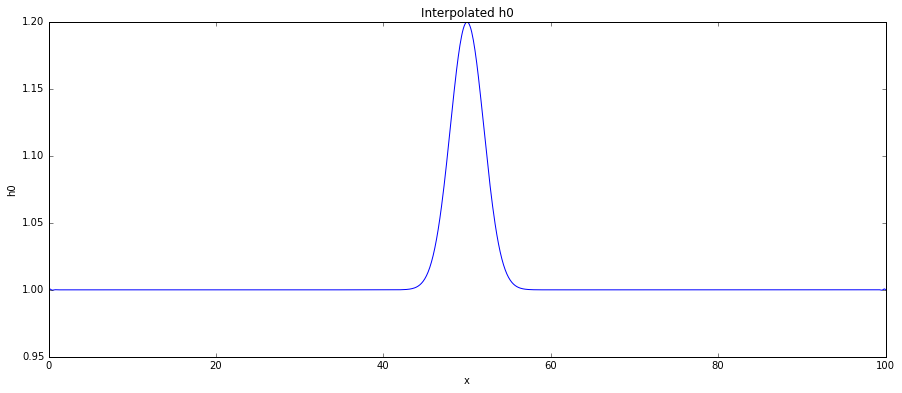

In [13]:
x = np.linspace(Xi_h[0], Xi_h[-1], 1000)
plt.figure(figsize=(15,6))
plt.plot(x, h(x, Gamma_h, Xi_h, Eps_h))
plt.xlabel('x')
plt.ylabel('h0')
plt.title('Interpolated h0')
plt.show()

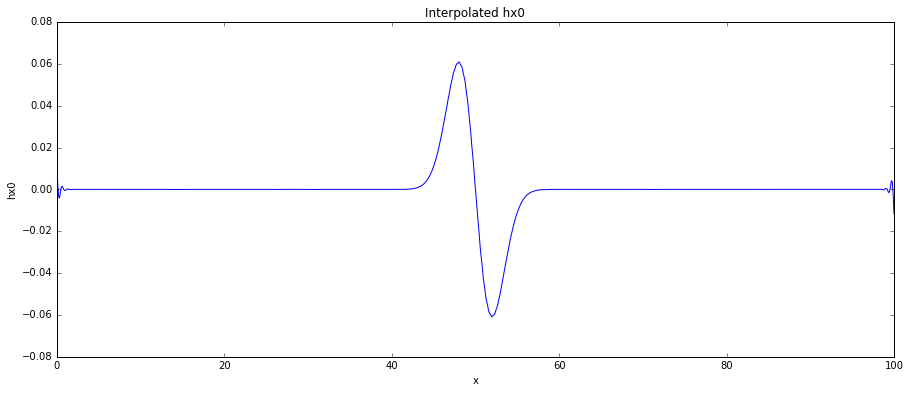

In [14]:
plt.figure(figsize=(15,6))
plt.plot(x, hx(x, Gamma_h, Xi_h, Eps_h))
plt.xlabel('x')
plt.ylabel('hx0')
plt.title('Interpolated hx0')
plt.show()

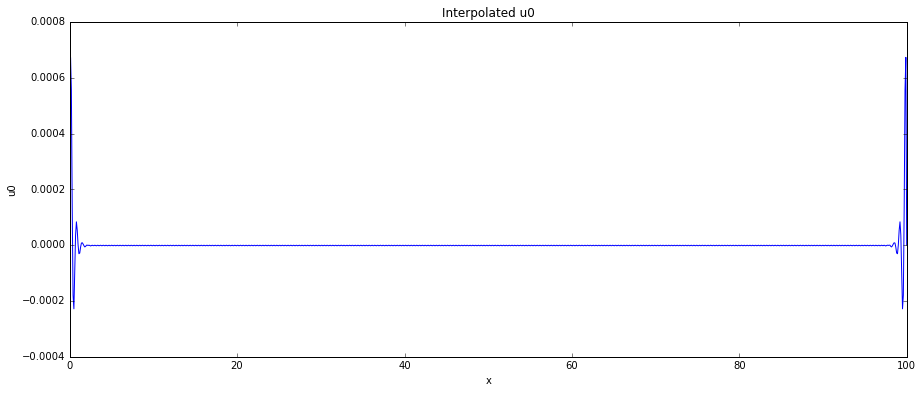

In [15]:
plt.figure(figsize=(15,6))
plt.plot(x, u(x, Gamma_u, Xi_u, Eps_u))
plt.xlabel('x')
plt.ylabel('u0')
plt.title('Interpolated u0')
plt.show()

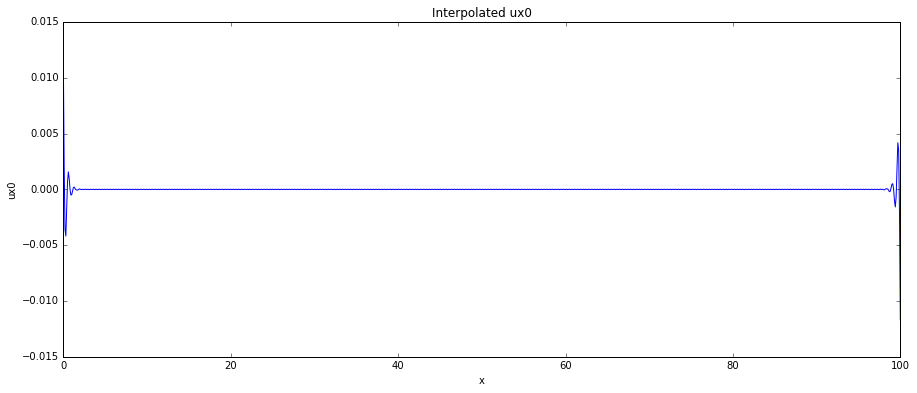

In [16]:
plt.figure(figsize=(15,6))
plt.plot(x, ux(x, Gamma_u, Xi_u, Eps_u))
plt.xlabel('x')
plt.ylabel('ux0')
plt.title('Interpolated ux0')
plt.show()

### Ecuaciones de Evolución

\begin{align}
\gamma _h'(t) &= -\left(\frac{H}{N} + \gamma _h(t)\right)u_x  \\
\xi _h'(t) &= u \\
\epsilon _h'(t) &= \frac{H \ u_x \ \epsilon_h(t)}{2 N \ \gamma_h(t)} \\
\  \\
\gamma _u'(t) &= -\frac{g h_x}{N} \\
\xi _u'(t) &= u \\
\epsilon _u'(t) &= \frac{g \ h_x \ \epsilon _u(t)}{2 N \ \gamma_u(t)}
\end{align}

**Comentarios:**
1. Las partículas de altura y de velocidad se mueven de manera conjunta, manteniendo sus centros.

In [17]:
def residual():
    pass

In [18]:
def F(X, t):
    #unpacking parameters
    Gamma_h = X[0:N] 
    Xi_h = X[N:2*N]
    Eps_h = X[2*N:3*N]
    Gamma_u = X[3*N:4*N]
    Xi_u = X[4*N:5*N]
    Eps_u = X[5*N:6*N]
    
    #computing derivatives at time t (autonomous system)
    f1 = -(H/N + Gamma_h) * ux(Xi_h, Gamma_u, Xi_u, Eps_u)
    f2 = u(Xi_h, Gamma_u, Xi_u, Eps_u)
    f3 = np.divide(H*ux(Xi_h, Gamma_u, Xi_u, Eps_u)*Eps_h, 2.*N*Gamma_h)
    f4 = -(g/N)*hx(Xi_u, Gamma_h, Xi_h, Eps_h)
    f5 = u(Xi_u, Gamma_u, Xi_u, Eps_u)
    f6 = np.divide(g*hx(Xi_u, Gamma_h, Xi_h, Eps_h)*Eps_u, 2.*N*Gamma_u)
    
    #returning values as flattened array
    return np.array([f1,f2,f3,f4,f5,f6]).ravel()

# SWE INT

In [19]:
#initial conditions vector
X0 = np.array([Gamma_h, Xi_h, Eps_h, Gamma_u, Xi_u, Eps_u]).ravel()

#times
t_start = 0.
t_end = 50.
t_step = 0.01

In [20]:
def sweint(F, X0, t_start, t_end, t_step):
    #setting ode object
    func = lambda t,X : F(X,t)
    ode = spi.ode(func)
    ode.set_integrator('vode', nsteps=1000, method='bdf')
    #ode.set_integrator('dopri5', nsteps=1000)
    ode.set_initial_value(X0, t_start)
    
    #return array
    nrow = int(t_end/t_step)
    ncol = len(X0)
    ret = np.empty((nrow,ncol))
    r_index = 0
    
    #integrate it!
    while ode.t < t_end:
        #integration step
        ode.integrate(ode.t + t_step)
        #computing remeshing condition
        if not ode.successful():
            print "Warning: remeshing on iter {0} of {1}".format(r_index, nrow)
            #unpacking last solution
            X = ret[r_index-1]
            Gamma_h = X[0:N] 
            Xi_h = X[N:2*N]
            Eps_h = X[2*N:3*N]
            Gamma_u = X[3*N:4*N]
            Xi_u = X[4*N:5*N]
            Eps_u = X[5*N:6*N]
            print 'min Gamma_u', np.min(Gamma_u)
            
            #computing new parameters
            xi_h = np.linspace(a, b, N, endpoint=True)
            xi_u = np.linspace(a, b, N, endpoint=True)
            x0_h = xi_h.reshape((N,1))
            x0_u = xi_u.reshape((N,1))
            eps_h = 3.
            eps_u = 3.
            gamma_h = np.linalg.solve(phi(x0_h, xi_h, eps_h), h(xi_h, Gamma_h, Xi_h, Eps_h)-H)
            gamma_u = np.linalg.solve(phi(x0_u, xi_u, eps_u), u(xi_u, Gamma_u, Xi_u, Eps_u)-U)
            eps_h = np.array([eps_h]*N)
            eps_u = np.array([eps_u]*N)
            X0 = np.array([gamma_h, xi_h, eps_h, gamma_u, xi_u, eps_u]).ravel()
            print 'min gamma_u', np.min(gamma_u)
            t_start = ode.t
            ode.set_initial_value(X0, t_start)
            continue
        #print 'min gamma_u:', np.min(X[3*N:4*N])
        #print np.argmin(X[3*N:4*N])
        #print np.mean(X[3*N:4*N])
        #print 'min eps_u:', np.max(X[5*N:6*N])
        #print np.argmax(X[5*N:6*N])
        #Gamma_h = X[0:N] 
        #Xi_h = X[N:2*N]
        #Eps_h = X[2*N:3*N]
        #Gamma_u = X[3*N:4*N]
        #Xi_u = X[4*N:5*N]
        #Eps_u = X[5*N:6*N]
        ret[r_index] = ode.y
        r_index += 1
        #print '-------------------------'
    return ret

In [ ]:
sol = sweint(F, X0, t_start, t_end, t_step)

min Gamma_u 3.29356698272e-06
min gamma_u -3.61516558678e-05

In [134]:
X = sol[4500]; print X

[  8.22884715e-03  -8.26621482e-04   6.35027718e-03 ...,   2.88118471e+00
   3.15792835e+00   3.00069991e+00]


In [135]:
Gamma_h = X[0:N] 
Xi_h = X[N:2*N]
Eps_h = X[2*N:3*N]
Gamma_u = X[3*N:4*N]
Xi_u = X[4*N:5*N]
Eps_u = X[5*N:6*N]

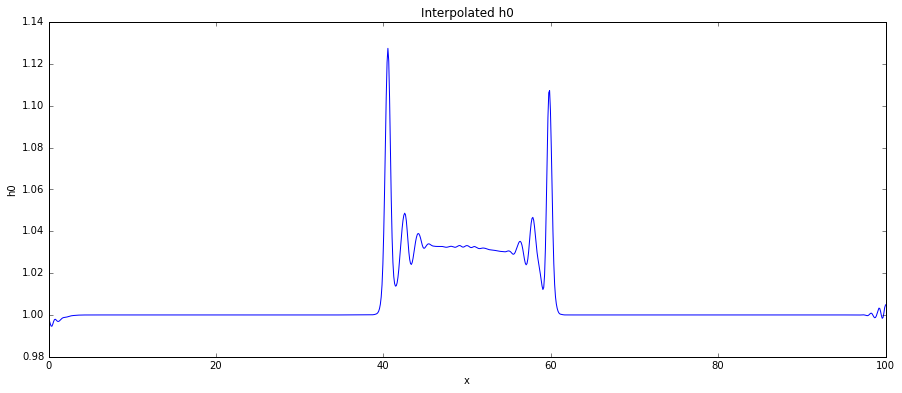

In [136]:
plt.figure(figsize=(15,6))
plt.plot(x, h(x, Gamma_h, Xi_h, Eps_h))
plt.xlabel('x')
plt.ylabel('h0')
plt.title('Interpolated h0')
plt.show()

# Plotting parameters in time

In [92]:
t = np.arange(t_start, t_end, t_step)

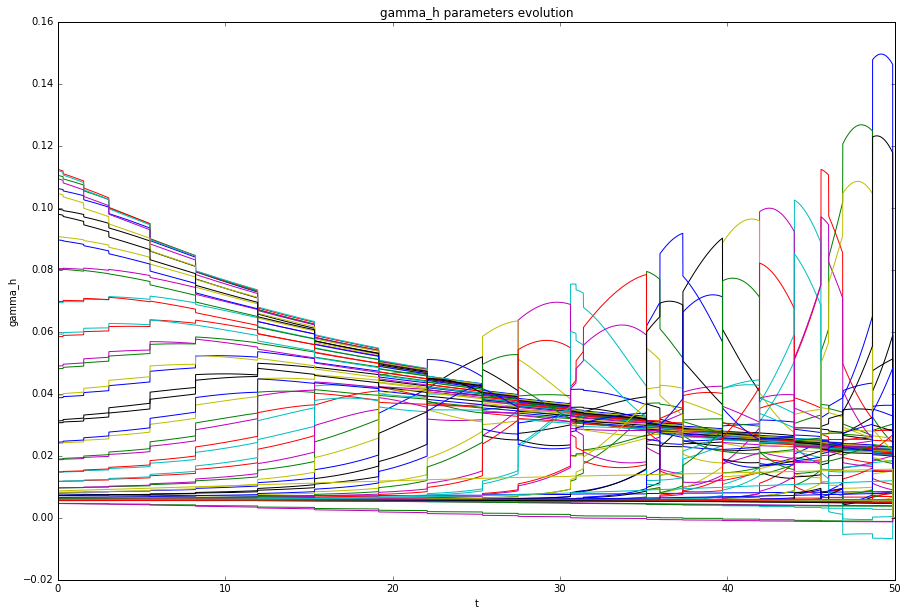

In [93]:
plt.figure(figsize=(15,10))
plt.plot(t, sol[:,0:N])
plt.xlabel('t')
plt.ylabel('gamma_h')
plt.title('gamma_h parameters evolution')
plt.show()

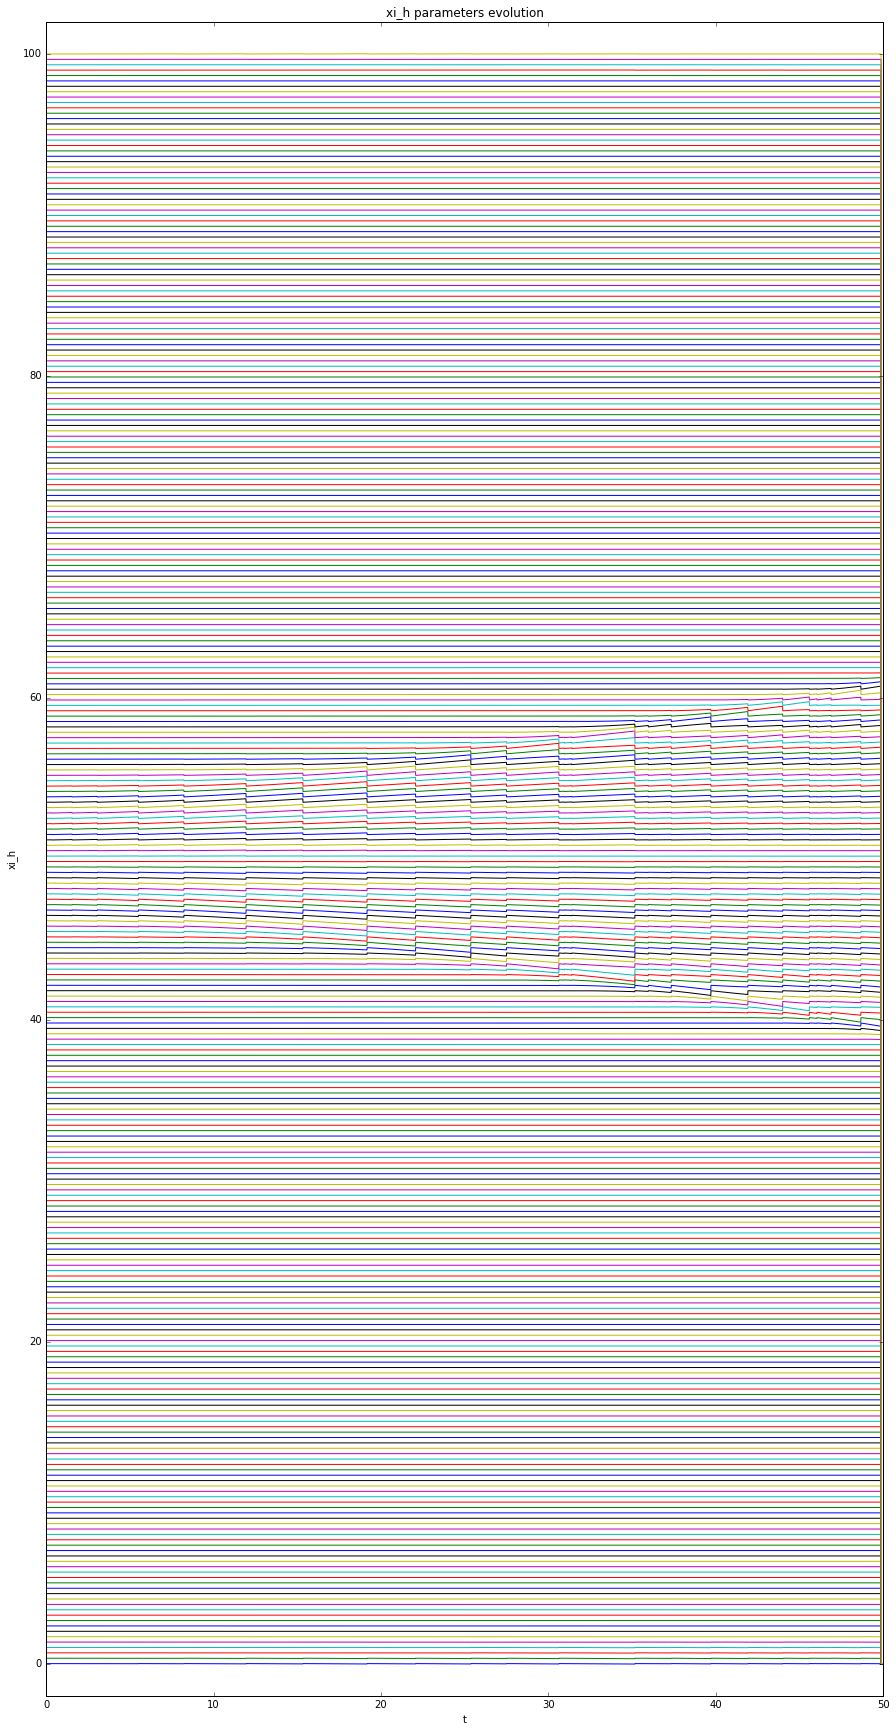

In [94]:
plt.figure(figsize=(15,30))
plt.axes(ylim=(-2, 102))
plt.plot(t, sol[:,N:2*N])
plt.xlabel('t')
plt.ylabel('xi_h')
plt.title('xi_h parameters evolution')
plt.show()

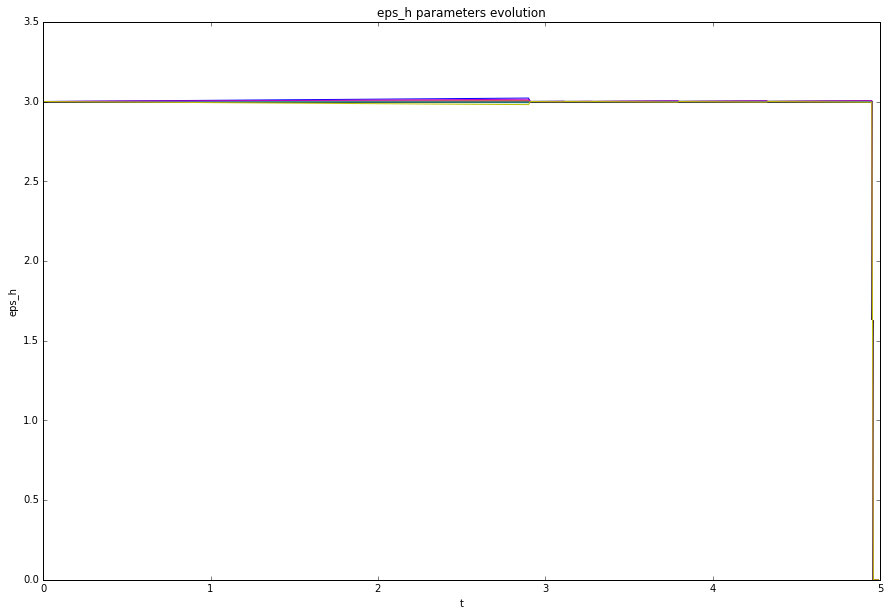

In [67]:
plt.figure(figsize=(15,10))
plt.plot(t, sol[:,2*N:3*N])
plt.xlabel('t')
plt.ylabel('eps_h')
plt.title('eps_h parameters evolution')
plt.show()

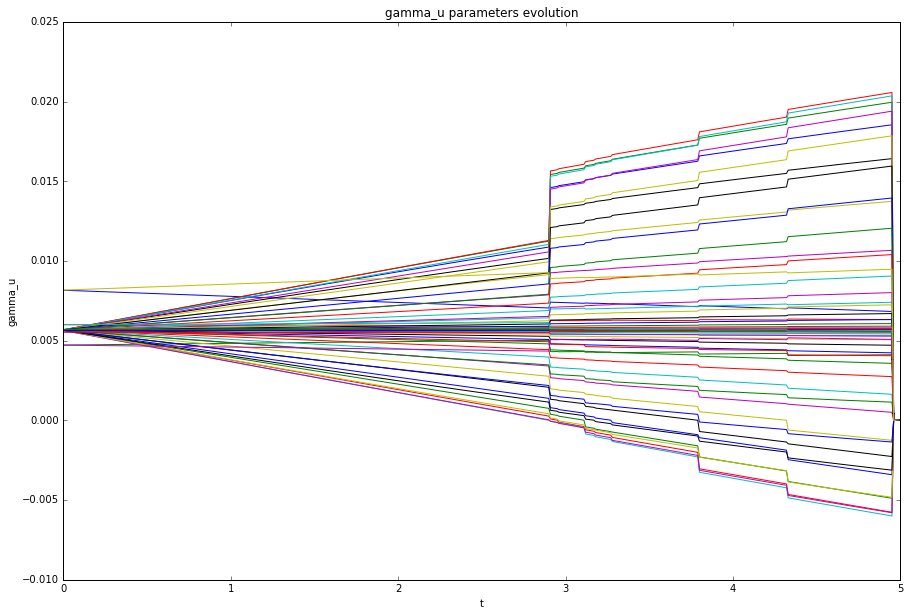

In [68]:
plt.figure(figsize=(15,10))
plt.plot(t, sol[:,3*N:4*N])
plt.xlabel('t')
plt.ylabel('gamma_u')
plt.title('gamma_u parameters evolution')
plt.show()

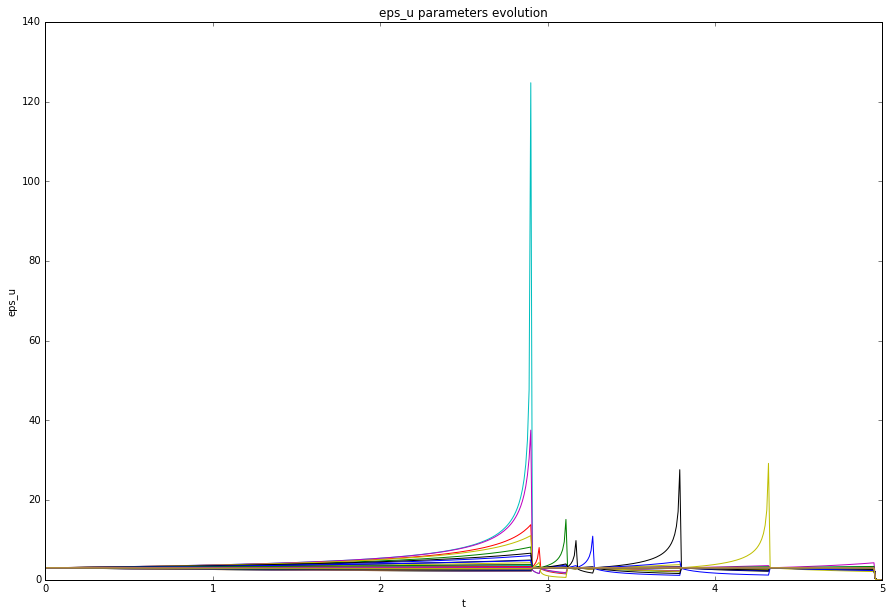

In [69]:
plt.figure(figsize=(15,10))
plt.plot(t, sol[:,5*N:6*N])
plt.xlabel('t')
plt.ylabel('eps_u')
plt.title('eps_u parameters evolution')
plt.show()

# 3D Solution

In [43]:
#generating grids
X, T = np.meshgrid(x, t)

W = np.empty((len(t),len(x)))
m = 0
for s in sol:
    Gamma_h = s[0:N] 
    Xi_h = s[N:2*N]
    Eps_h = s[2*N:3*N]
    Gamma_u = s[3*N:4*N]
    Xi_u = s[4*N:5*N]
    Eps_u = s[5*N:6*N]
    W[m] = h(x, Gamma_h, Xi_h, Eps_h)
    m +=1

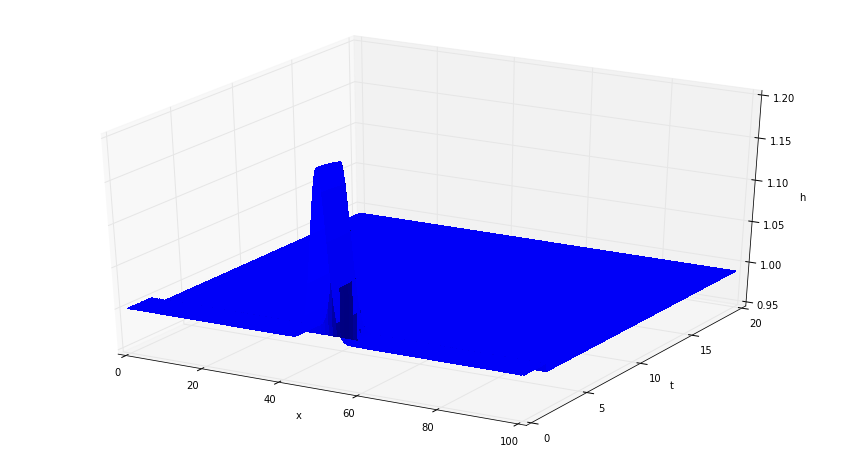

In [44]:
#3d plot
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, W, antialiased=False, linewidth=0)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')
#ax.view_init(elev=0., azim=10)
#plt.contour(X, T, W)
#plt.savefig('h_evolution.png')
plt.show()

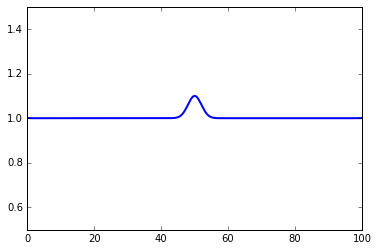

In [177]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(a,b), ylim=(0.5, 1.5))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    X = sol[i]
    #unpacking
    Gamma_h = X[0:N] 
    Xi_h = X[N:2*N]
    Eps_h = X[2*N:3*N]
    Gamma_u = X[3*N:4*N]
    Xi_u = X[4*N:5*N]
    Eps_u = X[5*N:6*N]
    y = h(x, Gamma_h, Xi_h, Eps_h)
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=30, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
#anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
anim.save('swe1D.mp4', fps=30, extra_args=['-vcodec', 'libx264'])